[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Algebra_Lineal/blob/main/semana5/Image-denoising-LPGPCA.ipynb)

# Fondo del problema

El ruido en las imágenes está constituido por variaciones aleatorias en el brillo o puede ser la información de los colores en una imagen. Hay múltiples fuentes de ruido en las imágenes, pueden ser desde ruido que se crea en la imagen por el modo en que es capturada (variación de la luz, calidad de la cámara, sensores de imagen) hasta ruido introducido por el modo en que es almacenada la imagen.

# Funciones a utilizar (para comparativos)

- PSNR(Peak Signal-to-Noise Ratio)

PSNR es un término de ingeniería para el radio entre el valor máximo de una señal y el poder de ruido que afecta la fidelidad de la representación.

PSNR (en decibeles) se define como:

<center> <img src='https://camo.githubusercontent.com/3c6b377cc6af3bfa5c81c942ad52809721c2b02eecc5aef5e8778192ac323312/68747470733a2f2f77696b696d656469612e6f72672f6170692f726573745f76312f6d656469612f6d6174682f72656e6465722f7376672f66633232383031656431323332666631323331633431353662353839646535633332303633613861'> </center>

Donde MSE es el error cuadratico medio entre una imagen inicial monocromática y una aproximación que tiene ruido.

- SSIM (Structural Similarity)

Este método está mas interesado en utilizar la idea de que los pixeles son fuertemente interdependientes (especialmente de sus vecinos cercanos). Utiliza máscaras de iluminación y de contraste.

<center> <img src='https://camo.githubusercontent.com/878b146cdcc67977e298fc950345e5881698ab18682f22e6d975e5998d2170f4/68747470733a2f2f77696b696d656469612e6f72672f6170692f726573745f76312f6d656469612f6d6174682f72656e6465722f7376672f36333334396633656531376533393639313566366332353232316165343838633362623534623636'> </center>

Obtenido de https://github.com/Gaurav-Pande/Image-Denoising 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import skimage

In [ ]:
# Revisar version del módulo skimage
skimage.__version__

'0.18.3'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import skimage as ski
from skimage.metrics import structural_similarity as ssim      # Antes de la version 0.18 de skimage, estaban en submodulo measure
from skimage.metrics import peak_signal_noise_ratio as psnr    # Antes de la version 0.18 de skimage, estaban en submodulo measure

In [ ]:
# Imagen paa pruebas
img_filename = '/content/drive/MyDrive/Curso-Algebra/semana5/cameraman.tif'
img_prueba = plt.imread(img_filename).astype(dtype=float)

In [ ]:
img_prueba

array([[156., 159., 158., ..., 151., 152., 152.],
       [160., 154., 157., ..., 154., 155., 153.],
       [156., 159., 158., ..., 151., 152., 152.],
       ...,
       [114., 132., 123., ..., 135., 137., 114.],
       [121., 126., 130., ..., 133., 130., 113.],
       [121., 126., 130., ..., 133., 130., 113.]])

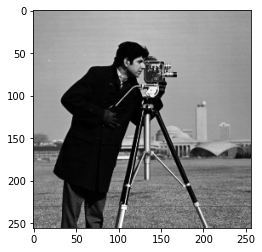

In [ ]:
plt.imshow(img_prueba, cmap='gray')

In [ ]:
def getpca(X):
    # %X: MxN matrix
    # %Y: Y=P*X
    # %P: matriz de transformación
    # %V: los eigenvalores ordenados en la salida

    [M, N] = X.shape

    mx = (np.mean(X, axis=1)).reshape((M, 1))

    X = X - mx

    CovX = (X @ X.T) / (N-1)
    [V, P]= np.linalg.eig(CovX)

    V_minus = -1 * V
    ind = np.argsort(V_minus, axis=0)

    V = V[ind];
    P = P[:, ind]

    P = P.T
    Y = np.matmul(P, X)
    # Y = P @ X

    # Pt @ Y = X
    # Pt = U
    # Y = D @ Vt
    # U @ D @ Vt = X
    # Y son los componentes principales
    # P son los loadings

    return [Y, P, V, mx]

In [ ]:
np.set_printoptions(suppress=True)
getpca(img_prueba)[2]

array([388285.54040314, 118509.67349474,  38871.51697632,  35096.35871114,
        23002.87407307,  20872.70588632,  14032.75383728,  12079.67014452,
         9835.0556509 ,   9414.24156558,   9041.44847998,   8531.46283866,
         8103.26020917,   6619.94332649,   5779.51969304,   5352.2338874 ,
         4930.62828759,   4034.61222204,   3845.25099736,   3578.55477539,
         3227.53550401,   2616.01335672,   2501.91741834,   2460.00557362,
         2264.46314422,   2157.15380446,   1922.75337982,   1801.94264422,
         1764.08349705,   1629.01834553,   1522.43584152,   1500.81085376,
         1355.24536552,   1289.28847294,   1194.54314056,   1151.56910108,
         1110.51467214,   1083.73927634,   1020.67302764,    974.54023741,
          905.86921401,    866.17004808,    842.29603741,    803.00279715,
          768.54347668,    715.6881513 ,    703.3196487 ,    688.77422321,
          653.88730379,    611.26873386,    569.80628035,    558.27803392,
          537.4142182 ,  

In [ ]:
# Función utilizada para 'inflar' mis imágenes en blanco y negro
def blow_gray(B):
    [n, m] = B.shape
    n = 2 * n
    m = 2 * m
    A = np.zeros((n,m))

    A[0:n:2, 0:m:2] = B
    A[0:n:2, 1:m:2] = B
    A[1:n:2, 0:m:2] = B
    A[1:n:2, 1:m:2] = B

    return A

In [ ]:
def LPG_new(X, row, col, off, nv, S, I):
    """Local Pixel Grouping

    X: Matriz de MxN que tiene los "sample vectors" de x_v como vectores fila
    row: fila del centro del block variable
    col: columna del centro del block variable
    off: Nos da la posicion del vector en el centro del training block
    nv: Número mínimo de vectores a regresar de V.
    S: Mitad del tamaño del training block
    I: Matriz auxiliar para recuperar los vectores correpondientes a cada block variable
    """
    [N, M] = I.shape
    f2 = X.shape[1]

    # borde superior del variable block 
    rmin = max(row - S, 0)
    # borde inferior
    rmax = min(row + S + 1, N)
    # borde izquierdo
    cmin = max(col - S, 0)
    # Borde derecho
    cmax = min(col + S + 1, M)

    # print("rmin, rmax, cmin, cmax: ", rmin, rmax, cmin, cmax)
    # Obtenemos los índices de los vectores en el training block
    idx = I[rmin: rmax, cmin: cmax]
    idx = (idx.T).flatten()
    # Obtiene todas las vectores dentro del training block
    B = X[idx,:]
    # Vector del centro del variable/training block
    v = X[off,:]

    # calculamos la distancia entrada a entrada de cada variable block respecto a la del vector del centro
    dis = ((B[:, 0] - v[0])**2)
    dis = dis.reshape((dis.shape[0], 1))

    for k in range(1, f2):
        # print("k: ", k)
        # k = int(k/S)
        dis_partial = ((B[:, k] - v[k])**2)
        dis_partial = dis_partial.reshape((dis_partial.shape[0], 1))
        dis = dis + dis_partial

    dis = dis/f2
    # Se ordenan de menor a mayor
    ind = np.argsort(dis, axis=0)
    # Se obtiene los nv vectores con menor distancia
    indc = idx[ind[0:nv]]

    return indc

In [ ]:
def dim_reduction(X):
    n = X.shape[0]
    n = math.floor(n * 0.4)
    [coe, P, V, mX] = getpca(X)
    Y = P[0 : n, :] @ X
    return Y

In [ ]:
# LPG de local pixel grouping
def LPGPCA_denoising(noise_img, orig_img, std, profile, K):
    s = 2
    if profile == 'fast':
        s = 2
    elif profile == 'normal':
        s = 1

    [n, m] = orig_img.shape
    [h, w] = noise_img.shape

    ##############First stage denoising###############

    v2 = std**2
    #training block(2k + 1) * (2k + 1)
    S = 20
    # variable block(2t + 1) * (2t + 1)
    t = 3
    nblk = 250
    b = 2 * t + 1
    b2 = b * b

    k = 0
    # Número de filas que tienen pixeles a eliminar ruido
    N = h - b + 1
    # Número de columnas que tienen pixeles a eliminar ruido
    M = w - b + 1
    # Cantidad de pixeles que pueden ser centro de "variable block"
    L = N * M
    r = np.arange(0, N, s)
    # ¿La última entrada de r es menor a N-1? No
    if r[-1] < (N - 1):
        r = np.hstack((r, np.arange(r[-1], N, 1)))

    c = np.arange(0, M, s)
    if c[-1] < (M - 1):
        c = np.hstack((c, np.arange(c[-1], M, 1)))

    # Matrix para alojar todos los posibles bloques
    X = np.zeros((b*b, L))

    # i recorre la matriz de arriba a abajo
    # j de izquierda a derecha
    # Cuando i,j = 0, se llena la primera entrada de todos los posibles bloques (variable block) y avanza para llenas las demás 
    for i in range(b):
        for j in range(b):
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1)]
            blk = (blk.T).flatten()
            X[k, :] = blk
            k = k + 1

    if profile == 'fast':
        X1 = dim_reduction(X)
        XT = X1.T
    else:
        XT = X.T

    # Matriz auxiliar para recuperar los vectores correpondientes a cada variable block 
    I = np.arange(L)
    I = (I.reshape((M, N))).T
    # I = (I.reshape((N, M))).T

    N1 = len(r)
    M1 = len(c)
    L = N1 * M1
    Y = np.zeros((b2, L))
    
    # Para cada fila en la que puede haber un pixel a quitar ruido (centro del variable block )
    for i in range(N1):
        # Para cada columna en la que puede haber un pixel a quitar ruido (centro del variable block)
        for j in range(M1):
            # para profile = 'normal', se selección el centro de cada variable block,
            # de izquierda a derecha, de arriba a abajo
            row = r[i]
            col = c[j]
            # El índice del vector en X, correpondiente al centro  del variable block
            off = (col * N) + row
            off1 = (j * N1) + i

            # Se obtienen los índices de los nblk-th vectores más cercanos de acuerdo a una métrica
            indc = LPG_new(XT, row, col, off, nblk, S, I)
            indc = indc.flatten()
            # PCA sobre los vectores más cercanos al 'pixel to be denoised'
            [coe, P, V, mX] = getpca(X[:, indc])
            # Varianza de Y = coe
            py = np.mean(coe**2, axis=1)
            # Se transforma a vector columna
            py = py.reshape((py.shape[0], 1))
            # omega_y_v - omega_vy <= 0
            px = np.maximum(np.zeros(py.shape), py - v2)
            # px = np.clip((py - v2), a_min=0.0, a_max=np.max(py - v2))
            wei = px/py 
            partial = ((coe[:, 0]).T * (wei.T)).T
            partial2 = P.T @ partial
            partial3 = mX[:, 0]
            partial3 = partial3.reshape((partial3.shape[0], 1))

            Y[:, off1] = (partial2 + partial3)[:, 0]
            # Y[:, off1] = (P.T @ (coe[:,0] * wei)) + mX[:,0]


    # Output the processed image
    dI = np.zeros((h, w))
    im_wei = np.zeros((h, w))
    k = 0
    for i in range(b):
        for j in range(b):
            # dI[i:(r[-1] + i + 1), j:(c[-1] + j + 1)] = dI[i:(r[-1] + i + 1), j:(c[-1] + j + 1)] + (Y[k, :]).reshape((N1, M1))
            # im_wei[i:(r[-1] + i + 1), j:(c[-1] + j + 1)] = im_wei[i:(r[-1] + i + 1), j:(c[-1] + j + 1)] + 1
            rv, cv = np.meshgrid(r+i, c+j)
            dI[rv, cv] = dI[rv, cv] + (Y[k, :].T).reshape((N1, M1))
            im_wei[rv, cv] = im_wei[rv, cv] + 1
            k = k + 1

    print("dI.max: ", np.max(dI))
    print("dI.min: ", np.min(dI))
    print("imwei.max: ", np.max(im_wei))
    print("imwei.min: ", np.min(im_wei))

    eps = 1e-23
    dI = dI/(im_wei + eps)

    print("dI.max: ", np.max(dI))
    print("dI.min: ", np.min(dI))

    # dI = np.fliplr(dI)
    # dI = np.rot90(dI)

    # plt.imsave('basic_lpgpca.png', dI[K: (n - K), K:(m - K)]/255, cmap='gray')
    # dI = plt.imread('basic_lpgpca.png').astype(dtype=np.float)
    # plt.imsave('basic_lpgpca.png', dI / 255, cmap='gray')
    # dI = dI/255

    # dI = np.clip(dI, a_min=0, a_max=255)
    psnr_1 = 0
    ssim_1 = 0

    plt.imshow(dI, cmap='gray')
    plt.title('primer paso procesamiento')
    plt.show()

    row, col = orig_img.shape
    # psnr_1 = psnr(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])
    # ssim_1 = ssim(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])

    # orig_img_crop = (orig_img[K : (row - K), K : (col - K)]).astype(dtype=np.int)
    # dI_crop = (dI[K : (row - K), K : (col - K)]).astype(dtype=np.int)
    orig_img_crop = orig_img.astype(dtype=int)
    dI_crop = dI.astype(dtype=int)
    psnr_1 = psnr(orig_img_crop, dI_crop)
    ssim_1 = ssim(orig_img_crop, dI_crop)


    # plt.imshow(blow_gray(dI[(K + 1): (n - K), (K + 1): (m - K)]), vmin = 0, vmax = 255, cmap='gray')
    # plt.show()

    dif = dI[(K) : (n - K), (K) : (m - K)] - noise_img[(K) : (n - K), (K) : (m - K)]
    print ("mean diff: ", np.mean(dif**2))
    vd = std**2 - np.mean(dif**2)
    v1 = math.sqrt(abs(vd))
    print ("v1: ", v1)

    #
    #-----------------------------------------------------------------
    # The second stage: refinement
    #-----------------------------------------------------------------

    psnr_2 = 0
    ssim_2 = 0

    noise_img = dI
    v = v1 * 0.36
    v2 = v**2

    k = 0
    N = h - b + 1
    M = w - b + 1
    L = N * M
    r = np.arange(0, N, s)
    if r[-1] < (N - 1):
        r = np.hstack((r, np.arange(r[-1], N, 1)))

    c = np.arange(0, M, s)
    if c[-1] < (M - 1):
        c = np.hstack((c, np.arange(c[-1], M, 1)))

    X = np.zeros((b*b, L))

    for i in range(b):
        for j in range(b):
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1)]
            # blk = noise_img[i : (h - b + i), j : (w - b + j)]
            blk = (blk.T).flatten()
            X[k, :] = blk
            k = k + 1

    if profile == 'fast':
        X1 = dim_reduction(X)
        XT = X1.T
    else:
        XT = X.T

    I = np.arange(L)
    I = (I.reshape((M, N))).T

    N1 = len(r)
    M1 = len(c)
    L = N1 * M1
    Y = np.zeros((b2, L))

    for i in range(N1):
        for j in range(M1):
            row = r[i]
            col = c[j]
            off = (col * N) + row
            off1 = (j * N1) + i

            indc = LPG_new(XT, row, col, off, nblk, S, I)
            indc = indc.flatten()
            [coe, P, V, mX] = getpca(X[:, indc])
            py = np.mean(coe**2, axis=1)
            py = py.reshape((py.shape[0], 1))
            # px = max(0, py - v2)
            px = np.maximum(np.zeros(py.shape), py - v2)
            wei = px/py
            partial = ((coe[:, 0]).T * (wei.T)).T
            partial2 = P.T @ partial
            partial3 = mX[:, 0]
            partial3 = partial3.reshape((partial3.shape[0], 1))

            Y[:, off1] = (partial2 + partial3)[:, 0]
            # Y[:, off1] = (P.T @ (coe[:,0] * wei)) + mX[:,0]


    # Output the processed image
    dI = np.zeros((h, w))
    im_wei = np.zeros((h, w))
    k = 0

    for i in range(b):
        for j in range(b):
            # dI[(r + i), (c + j)] = dI[(r + i), (c + j)] + (Y[k , :].T).reshape((N1, M1))
            # im_wei[(r + i), (c + j)] = im_wei[(r + i), (c + j)] + 1
            # dI[i:(r[-1] + i + 1), j:(c[-1] + j + 1)] = dI[i:(r[-1] + i + 1), j:(c[-1] + j + 1)] + (Y[k, :].T).reshape((N1, M1))
            rv, cv = np.meshgrid(r+i, c+j)
            dI[rv, cv] = dI[rv, cv] + (Y[k, :].T).reshape((N1, M1))
            im_wei[rv, cv] = im_wei[rv, cv] + 1
            k = k + 1

    eps = 1e-23
    dI = dI/(im_wei + eps)

    # plt.imsave('final_lpgpca_int.png', dI[K: (n - K), K:(m - K)]/255, cmap='gray')
    # dI = plt.imread('basic_lpgpca.png').astype(dtype=np.float)
    # plt.imsave('basic_lpgpca.png', dI / 255, cmap='gray')
    # dI = dI/255

    # dI = np.clip(dI, a_min=0, a_max=255)

    # psnr_1 = csnr(orig_img, dI, K, K)
    # ssim_1 = cal_ssim(orig_img, dI, K, K)

    row, col = orig_img.shape
    # psnr_2 = psnr(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])
    # ssim_2 = ssim(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])

    # psnr_2 = psnr(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)], data_range=float)
    # ssim_2 = ssim(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])

    print("dI2.max: ", np.max(dI))
    print("dI2.min: ", np.min(dI))

    # orig_img_crop = (orig_img[K : (row - K), K : (col - K)]).astype(dtype=np.int)
    # dI_crop = (dI[K : (row - K), K : (col - K)]).astype(dtype=np.int)
    orig_img_crop = orig_img.astype(dtype=int)
    dI_crop = dI.astype(dtype=int)

    # Comparaciones
    psnr_2 = psnr(orig_img_crop, dI_crop)
    ssim_2 = ssim(orig_img_crop, dI_crop)


    # plt.imshow(blow_gray(dI[(K + 1): (n - K), (K + 1): (m - K)]), vmin = 0, vmax = 255, cmap='gray')
    # plt.show()
    plt.imshow(dI, cmap='gray')
    plt.title('Output de imagen procesada')
    plt.show()

    d_im = dI[K:n-K, K:m-K]

    return [d_im, psnr_1, ssim_1, psnr_2, ssim_2]

orig_img.shape:  (256, 256)
orig_img.max:  253.0
orig_img.min:  7.0


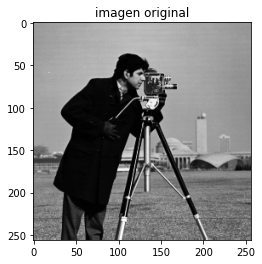

noise_img.shape:  (256, 256)
noise_img.max:  299.9506920257019
noise_img.min:  -70.8975110228373


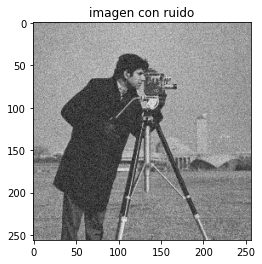

dI.max:  13573.481242802167
dI.min:  -1069.7930526809696
imwei.max:  49.0
imwei.min:  1.0
dI.max:  277.00982128167686
dI.min:  -21.832511279203462


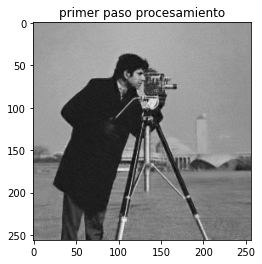

mean diff:  282.20249202582903
v1:  10.853456038247494
dI2.max:  274.2870424443483
dI2.min:  -18.149441848391913


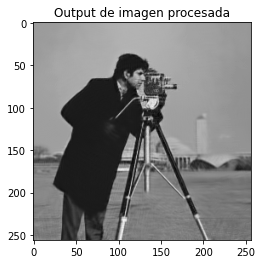

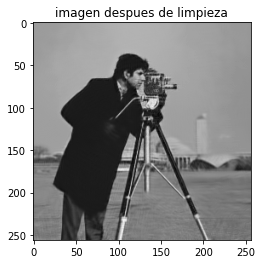

psnr1:  360.753263494324
ssim1:  1.0
psnr2:  360.98322064512416
ssim2:  1.0


In [ ]:
# APROX 8:28 ejecucion
profile = 'normal'
# profile = 'fast'
std = 20
img_filename = '/content/drive/MyDrive/Curso-Algebra/semana5/cameraman.tif'
orig_img = plt.imread(img_filename).astype(dtype=float)
print("orig_img.shape: ", orig_img.shape)
print("orig_img.max: ", np.max(orig_img))
print("orig_img.min: ", np.min(orig_img))
plt.imshow(orig_img, cmap='gray')
plt.title('imagen original')
plt.show()

seed = 0
random.seed(seed)

noise = np.random.normal(size=(orig_img.shape))
noise = noise/np.sqrt(np.mean(noise**2))
noise_img = orig_img + (std * noise)
print("noise_img.shape: ", noise_img.shape)
print("noise_img.max: ", np.max(noise_img))
print("noise_img.min: ", np.min(noise_img))
plt.imshow(noise_img, cmap='gray')
plt.title('imagen con ruido')
plt.show()

# plt.imsave('noise_'+img_filename[:-3]+'png', noise_img, cmap='gray')

#The width of the excluded boundaries, set to 20 to get the results in our paper
bound_exclude_width = 0

[denoise_img, psnr1, ssim1, psnr2, ssim2] =\
    LPGPCA_denoising(noise_img, orig_img, std, profile, bound_exclude_width);

# plt.imsave('denoised_'+img_filename[:-3]+'png', noise_img, cmap='gray')
# plt.imsave('denoised_'+img_filename[:-3]+'png', denoise_img, cmap='gray')

plt.imshow(denoise_img, cmap='gray')
plt.title('imagen despues de limpieza')
plt.show()

print("psnr1: ", psnr1)
print("ssim1: ", ssim1)
print("psnr2: ", psnr2)
print("ssim2: ", ssim2)

orig_img.shape:  (256, 256)
orig_img.max:  253.0
orig_img.min:  7.0


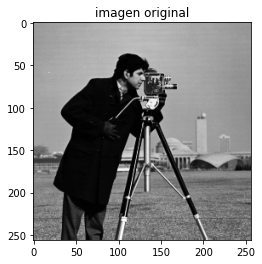

noise_img.shape:  (256, 256)
noise_img.max:  299.2744977961373
noise_img.min:  -75.81008681167752


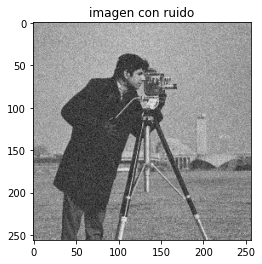

dI.max:  4292.396370837014
dI.min:  -349.6980449226282
imwei.max:  16.0
imwei.min:  1.0
dI.max:  273.16987477202434
dI.min:  -24.586834298429338


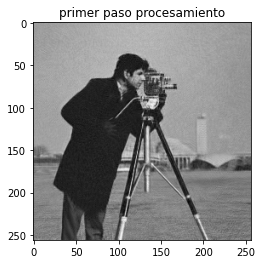

mean diff:  246.4443089920298
v1:  12.391758995718494
dI2.max:  271.0766943729074
dI2.min:  -21.950461022375165


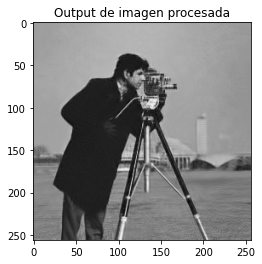

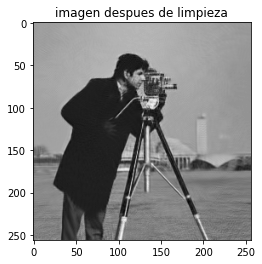

psnr1:  360.43439191695813
ssim1:  1.0
psnr2:  361.0532877929355
ssim2:  1.0


In [ ]:
# profile = 'normal'
profile = 'fast'
std = 20
img_filename = '/content/drive/MyDrive/Curso-Algebra/semana5/cameraman.tif'
orig_img = plt.imread(img_filename).astype(dtype=float)
print("orig_img.shape: ", orig_img.shape)
print("orig_img.max: ", np.max(orig_img))
print("orig_img.min: ", np.min(orig_img))
plt.imshow(orig_img, cmap='gray')
plt.title('imagen original')
plt.show()

seed = 0
random.seed(seed)

noise = np.random.normal(size=(orig_img.shape))
noise = noise/np.sqrt(np.mean(noise**2))
noise_img = orig_img + (std * noise)
print("noise_img.shape: ", noise_img.shape)
print("noise_img.max: ", np.max(noise_img))
print("noise_img.min: ", np.min(noise_img))
plt.imshow(noise_img, cmap='gray')
plt.title('imagen con ruido')
plt.show()

# plt.imsave('noise_'+img_filename[:-3]+'png', noise_img, cmap='gray')

#The width of the excluded boundaries, set to 20 to get the results in our paper
bound_exclude_width = 0

[denoise_img, psnr1, ssim1, psnr2, ssim2] =\
    LPGPCA_denoising(noise_img, orig_img, std, profile, bound_exclude_width);

# [denoise_img, psnr1, ssim1, psnr2, ssim2] =\
#     LPGPCA_denoising(noise_img[:-1, :], orig_img[:-1, :], std, profile, bound_exclude_width);

# plt.imsave('denoised_'+img_filename[:-3]+'png', noise_img, cmap='gray')
# plt.imsave('denoised_'+img_filename[:-3]+'png', denoise_img, cmap='gray')

plt.imshow(denoise_img, cmap='gray')
plt.title('imagen despues de limpieza')
plt.show()

print("psnr1: ", psnr1)
print("ssim1: ", ssim1)
print("psnr2: ", psnr2)
print("ssim2: ", ssim2)

# Opcional: Caso a Color

In [ ]:
def blow_color(B):
    [n, m, ch] = B.shape
    n = 2 * n
    m = 2 * m
    A = np.zeros((n,m,ch))

    A[0:n:2, 0:m:2, :] = B
    A[0:n:2, 1:m:2, :] = B
    A[1:n:2, 0:m:2, :] = B
    A[1:n:2, 1:m:2, :] = B

    return A

In [ ]:
img_filename = 'https://raw.githubusercontent.com/Gaurav-Pande/Image-Denoising/master/assets/original_png/0038.png' #'0038.png'
orig_img = plt.imread(img_filename).astype(dtype=float)
print("orig_img.shape: ", orig_img.shape)
print("orig_img.max: ", np.max(orig_img))
print("orig_img.min: ", np.min(orig_img))
plt.imshow(orig_img)
plt.show()

In [ ]:
plt.imshow(blow_color(orig_img))


In [ ]:
orig_img.shape , blow_color(orig_img).shape

In [ ]:
def LPGPCA_color_denoising(noise_img, orig_img, std, profile, K):
    s = 2
    if profile == 'fast':
        s = 2
    elif profile == 'normal':
        s = 2

    [n, m, ch] = orig_img.shape
    [h, w, ch] = noise_img.shape

    ##############First stage denoising###############

    v2 = std**2
    #training block(2k + 1) * (2k + 1)
    S = 20
    # variable block(2t + 1) * (2t + 1)
    t = 3
    nblk = 250
    b = 2 * t + 1
    b2 = b * b

    k = 0
    N = h - b + 1
    M = w - b + 1
    L = N * M
    r = np.arange(0, N, s)
    if r[-1] < (N - 1):
        r = np.hstack((r, np.arange(r[-1], N, 1)))

    c = np.arange(0, M, s)
    if c[-1] < (M - 1):
        c = np.hstack((c, np.arange(c[-1], M, 1)))

    X = np.zeros((b*b*ch, L))

    for i in range(b):
        for j in range(b):
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 0]
            blk = (blk.T).flatten()
            X[k, :] = blk
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 1]
            blk = (blk.T).flatten()
            X[k + b2, :] = blk
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 2]
            blk = (blk.T).flatten()
            X[k + (2 * b2), :] = blk
            k = k + 1

    if profile == 'fast':
        X1 = dim_reduction(X)
        XT = X1.T
    else:
        XT = X.T

    I = np.arange(L)
    I = (I.reshape((M, N))).T

    N1 = len(r)
    M1 = len(c)
    L = N1 * M1
    Y = np.zeros((b2*ch, L))

    for i in range(N1):
        for j in range(M1):
            row = r[i]
            col = c[j]
            off = (col * N) + row
            off1 = (j * N1) + i

            indc = LPG_new(XT, row, col, off, nblk, S, I)
            indc = indc.flatten()
            [coe, P, V, mX] = getpca(X[:, indc])
            py = np.mean(coe**2, axis=1)
            py = py.reshape((py.shape[0], 1))
            px = np.maximum(np.zeros(py.shape), py - v2)
            # px = np.clip((py - v2), a_min=0.0, a_max=np.max(py - v2))
            wei = px/py
            partial = ((coe[:, 0]).T * (wei.T)).T
            partial2 = P.T @ partial
            partial3 = mX[:, 0]
            partial3 = partial3.reshape((partial3.shape[0], 1))

            Y[:, off1] = (partial2 + partial3)[:, 0]
            # Y[:, off1] = (P.T @ (coe[:,0] * wei)) + mX[:,0]


    # Output the processed image
    dI = np.zeros((h, w, ch))
    im_wei = np.zeros((h, w, ch))
    k = 0
    for i in range(b):
        for j in range(b):
            rv, cv = np.meshgrid(r+i, c+j)
            dI[rv, cv, 0] = dI[rv, cv, 0] + (Y[k, :]).reshape((N1, M1))
            im_wei[rv, cv, 0] = im_wei[rv, cv, 0] + 1
            dI[rv, cv, 1] = dI[rv, cv, 1] + (Y[(k+b2), :]).reshape((N1, M1))
            im_wei[rv, cv, 1] = im_wei[rv, cv, 1] + 1
            dI[rv, cv, 2] = dI[rv, cv, 2] + (Y[k+(2*b2), :]).reshape((N1, M1))
            im_wei[rv, cv, 2] = im_wei[rv, cv, 2] + 1
            k = k + 1

    print("dI.max: ", np.max(dI))
    print("dI.min: ", np.min(dI))
    print("imwei.max: ", np.max(im_wei))
    print("imwei.min: ", np.min(im_wei))

    eps = 1e-23
    dI = dI/(im_wei + eps)

    print("dI.max: ", np.max(dI))
    print("dI.min: ", np.min(dI))

    # dI = np.fliplr(dI)
    # dI = np.rot90(dI)

    # plt.imsave('basic_lpgpca.png', dI[K: (n - K), K:(m - K)]/255, cmap='gray')
    # dI = plt.imread('basic_lpgpca.png').astype(dtype=np.float)
    # plt.imsave('basic_lpgpca.png', dI / 255, cmap='gray')
    # dI = dI/255

    # dI = np.clip(dI, a_min=0, a_max=255)
    psnr_1 = 0
    ssim_1 = 0
    ssim_2 = 0
    ssim_3 = 0
    ssim_1   = (ssim_1+ ssim_2+ ssim_3)/3;

    plt.imshow(dI)
    plt.show()
    plt.imsave('denoised_first.png', dI)

    # row, col = orig_img.shape
    # psnr_1 = psnr(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])
    # ssim_1 = ssim(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])

    # orig_img_crop = (orig_img[K : (row - K), K : (col - K)]).astype(dtype=np.int)
    # dI_crop = (dI[K : (row - K), K : (col - K)]).astype(dtype=np.int)
    # orig_img_crop = orig_img.astype(dtype=np.int)
    # dI_crop = dI.astype(dtype=np.int)
    # psnr_1 = psnr(orig_img_crop, dI_crop)
    # ssim_1 = ssim(orig_img_crop, dI_crop)


    # plt.imshow(blow_gray(dI[(K + 1): (n - K), (K + 1): (m - K)]), vmin = 0, vmax = 255, cmap='gray')
    # plt.show()

    dif_1 = dI[(K) : (n - K), (K) : (m - K), 0] - noise_img[(K) : (n - K), (K) : (m - K), 0]
    dif_2 = dI[(K) : (n - K), (K) : (m - K), 1] - noise_img[(K) : (n - K), (K) : (m - K), 1]
    dif_3 = dI[(K) : (n - K), (K) : (m - K), 2] - noise_img[(K) : (n - K), (K) : (m - K), 2]
    # print ("mean diff: ", np.mean(dif**2))
    vd_1 = std**2 - np.mean(dif_1**2)
    vd_2 = std**2 - np.mean(dif_2**2)
    vd_3 = std**2 - np.mean(dif_3**2)
    vd  = (vd_1 + vd_2 + vd_3)/3
    v1 = math.sqrt(abs(vd))
    print ("v1: ", v1)

    #
    #-----------------------------------------------------------------
    # The second stage: refinement
    #-----------------------------------------------------------------

    psnr_2 = 0
    ssim_2 = 0

    noise_img = dI
    v = v1 * 0.37
    v2 = v**2

    k = 0
    N = h - b + 1
    M = w - b + 1
    L = N * M
    r = np.arange(0, N, s)
    if r[-1] < (N - 1):
        r = np.hstack((r, np.arange(r[-1], N, 1)))

    c = np.arange(0, M, s)
    if c[-1] < (M - 1):
        c = np.hstack((c, np.arange(c[-1], M, 1)))

    X = np.zeros((b*b*ch, L))

    for i in range(b):
        for j in range(b):
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 0]
            blk = (blk.T).flatten()
            X[k, :] = blk
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 1]
            blk = (blk.T).flatten()
            X[k + b2, :] = blk
            blk = noise_img[i : (h - b + i + 1), j : (w - b + j + 1), 2]
            blk = (blk.T).flatten()
            X[k + (2 * b2), :] = blk
            k = k + 1

    if profile == 'fast':
        X1 = dim_reduction(X)
        XT = X1.T
    else:
        XT = X.T

    I = np.arange(L)
    I = (I.reshape((M, N))).T

    N1 = len(r)
    M1 = len(c)
    L = N1 * M1
    Y = np.zeros((b2 * ch, L))

    for i in range(N1):
        for j in range(M1):
            row = r[i]
            col = c[j]
            off = (col * N) + row
            off1 = (j * N1) + i

            indc = LPG_new(XT, row, col, off, nblk, S, I)
            indc = indc.flatten()
            [coe, P, V, mX] = getpca(X[:, indc])
            py = np.mean(coe**2, axis=1)
            py = py.reshape((py.shape[0], 1))
            # px = max(0, py - v2)
            px = np.maximum(np.zeros(py.shape), py - v2)
            wei = px/py
            partial = ((coe[:, 0]).T * (wei.T)).T
            partial2 = P.T @ partial
            partial3 = mX[:, 0]
            partial3 = partial3.reshape((partial3.shape[0], 1))

            Y[:, off1] = (partial2 + partial3)[:, 0]
            # Y[:, off1] = (P.T @ (coe[:,0] * wei)) + mX[:,0]


    # Output the processed image
    dI = np.zeros((h, w, ch))
    im_wei = np.zeros((h, w, ch))
    k = 0

    for i in range(b):
        for j in range(b):
            rv, cv = np.meshgrid(r+i, c+j)
            dI[rv, cv, 0] = dI[rv, cv, 0] + (Y[k, :]).reshape((N1, M1))
            im_wei[rv, cv, 0] = im_wei[rv, cv, 0] + 1
            dI[rv, cv, 1] = dI[rv, cv, 1] + (Y[(k+b2), :]).reshape((N1, M1))
            im_wei[rv, cv, 1] = im_wei[rv, cv, 1] + 1
            dI[rv, cv, 2] = dI[rv, cv, 2] + (Y[(k+2*b2), :]).reshape((N1, M1))
            im_wei[rv, cv, 2] = im_wei[rv, cv, 2] + 1
            k = k + 1

    eps = 1e-23
    dI = dI/(im_wei + eps)

    # plt.imsave('final_lpgpca_int.png', dI[K: (n - K), K:(m - K)]/255, cmap='gray')
    # dI = plt.imread('basic_lpgpca.png').astype(dtype=np.float)
    # plt.imsave('basic_lpgpca.png', dI / 255, cmap='gray')
    # dI = dI/255

    # dI = np.clip(dI, a_min=0, a_max=255)

    # psnr_1 = csnr(orig_img, dI, K, K)
    # ssim_1 = cal_ssim(orig_img, dI, K, K)

    # row, col = orig_img.shape
    psnr_2 = 0
    ssim_21 = 0
    ssim_22 = 0
    ssim_23 = 0
    ssim_2    = (ssim_21 + ssim_22 + ssim_23)/3
    # psnr_2 = psnr(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])
    # ssim_2 = ssim(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])

    # psnr_2 = psnr(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)], data_range=float)
    # ssim_2 = ssim(orig_img[K : (row - K), K : (col - K)], dI[K : (row - K), K : (col - K)])

    print("dI2.max: ", np.max(dI))
    print("dI2.min: ", np.min(dI))

    # orig_img_crop = (orig_img[K : (row - K), K : (col - K)]).astype(dtype=np.int)
    # dI_crop = (dI[K : (row - K), K : (col - K)]).astype(dtype=np.int)

    # orig_img_crop = orig_img.astype(dtype=np.int)
    # dI_crop = dI.astype(dtype=np.int)
    # psnr_2 = psnr(orig_img_crop, dI_crop)
    # ssim_2 = ssim(orig_img_crop, dI_crop)


    # plt.imshow(blow_gray(dI[(K + 1): (n - K), (K + 1): (m - K)]), vmin = 0, vmax = 255, cmap='gray')
    # plt.show()
    plt.imshow(dI)
    plt.show()
    plt.imsave('denoised_second.png', dI)

    d_im = dI[K:n-K, K:m-K, :]

    return [d_im, psnr_1, ssim_1, psnr_2, ssim_2]

In [ ]:
# profile = 'normal'
profile = 'fast'
std = 25
img_filename = 'https://raw.githubusercontent.com/Gaurav-Pande/Image-Denoising/master/assets/original_png/0038.png' #'0038.png'
orig_img = plt.imread(img_filename).astype(dtype=float)
print("orig_img.shape: ", orig_img.shape)
print("orig_img.max: ", np.max(orig_img))
print("orig_img.min: ", np.min(orig_img))
plt.imshow(orig_img)
plt.show()

# Utilizaremos una imagen que ya tiene ruido
noise_img = plt.imread('https://raw.githubusercontent.com/Gaurav-Pande/Image-Denoising/master/assets/noisy25/0038.png').astype(dtype=float)
print("noise_img.shape: ", noise_img.shape)
print("noise_img.max: ", np.max(noise_img))
print("noise_img.min: ", np.min(noise_img))
plt.imshow(noise_img)
plt.show()

# plt.imsave('noise_'+img_filename[:-3]+'png', noise_img, cmap='gray')

#The width of the excluded boundaries, set to 20 to get the results in our paper
bound_exclude_width = 0

[denoise_img, psnr1, ssim1, psnr2, ssim2] =\
    LPGPCA_color_denoising(noise_img[0:250, 0:250, :], orig_img[0:250, 0:250, :], std, profile, bound_exclude_width);

# plt.imsave('denoised_'+img_filename[:-3]+'png', noise_img, cmap='gray')
# plt.imsave('denoised_'+img_filename[:-3]+'png', denoise_img, cmap='gray')


plt.imshow(denoise_img)
plt.show()

print("psnr1: ", psnr1)
print("ssim1: ", ssim1)
print("psnr2: ", psnr2)
print("ssim2: ", ssim2)

In [ ]:
orig_img = plt.imread('https://raw.githubusercontent.com/Gaurav-Pande/Image-Denoising/master/assets/original_png/0038.png').astype(dtype=float)
orig_img = orig_img[:250, :250, :]
noise_img = plt.imread('https://raw.githubusercontent.com/Gaurav-Pande/Image-Denoising/master/assets/noisy25/0038.png').astype(dtype=float)
noise_img = noise_img[:250, :250, :]
denoise1_img = plt.imread('denoised_first.png').astype(dtype=float)
denoise2_img = plt.imread('denoised_second.png').astype(dtype=float)

denoise1_img = denoise1_img[:, :, 0:3]
denoise2_img = denoise2_img[:, :, 0:3]

# Estas imagenes se crean en el drive en el cuadro de código anterior
print("denoise1_img.shape: ", denoise1_img.shape)
print("denoise2_img.shape: ", denoise2_img.shape)
psnr_1 = psnr(orig_img, denoise1_img)
ssim_1 = ssim(orig_img, denoise1_img, multichannel=True)
psnr_2 = psnr(orig_img, denoise2_img)
ssim_2 = ssim(orig_img, denoise2_img, multichannel=True)

print("psnr1: ", psnr_1)
print("ssim1: ", ssim_1)
print("psnr2: ", psnr_2)
print("ssim2: ", ssim_2)

In [ ]:
profile = 'normal'
# profile = 'fast'
std = 25
img_filename = 'https://raw.githubusercontent.com/Gaurav-Pande/Image-Denoising/master/assets/original_png/0038.png'
orig_img = plt.imread(img_filename).astype(dtype=float)
print("orig_img.shape: ", orig_img.shape)
print("orig_img.max: ", np.max(orig_img))
print("orig_img.min: ", np.min(orig_img))
plt.imshow(orig_img)
plt.show()

seed = 0
random.seed(seed)

# Utilizaremos una imagen que ya tiene ruido
noise_img = plt.imread('https://raw.githubusercontent.com/Gaurav-Pande/Image-Denoising/master/assets/noisy25/0038.png').astype(dtype=float)
print("noise_img.shape: ", noise_img.shape)
print("noise_img.max: ", np.max(noise_img))
print("noise_img.min: ", np.min(noise_img))
plt.imshow(noise_img)
plt.show()

# plt.imsave('noise_'+img_filename[:-3]+'png', noise_img, cmap='gray')

#The width of the excluded boundaries, set to 20 to get the results in our paper
bound_exclude_width = 0

[denoise_img, psnr1, ssim1, psnr2, ssim2] =\
    LPGPCA_color_denoising(noise_img[0:250, 0:250, :], orig_img[0:250, 0:250, :], std, profile, bound_exclude_width);

# plt.imsave('denoised_'+img_filename[:-3]+'png', noise_img, cmap='gray')
# plt.imsave('denoised_'+img_filename[:-3]+'png', denoise_img, cmap='gray')


plt.imshow(denoise_img)
plt.show()

print("psnr1: ", psnr1)
print("ssim1: ", ssim1)
print("psnr2: ", psnr2)
print("ssim2: ", ssim2)

In [ ]:
orig_img = plt.imread('https://raw.githubusercontent.com/Gaurav-Pande/Image-Denoising/master/assets/original_png/0038.png').astype(dtype=float)
orig_img = orig_img[:250, :250, :]
noise_img = plt.imread('https://raw.githubusercontent.com/Gaurav-Pande/Image-Denoising/master/assets/noisy25/0038.png').astype(dtype=float)
noise_img = noise_img[:250, :250, :]
denoise1_img = plt.imread('denoised_first.png').astype(dtype=float)
denoise2_img = plt.imread('denoised_second.png').astype(dtype=float)

denoise1_img = denoise1_img[:, :, 0:3]
denoise2_img = denoise2_img[:, :, 0:3]

print("denoise1_img.shape: ", denoise1_img.shape)
print("denoise2_img.shape: ", denoise2_img.shape)
psnr_1 = psnr(orig_img, denoise1_img)
ssim_1 = ssim(orig_img, denoise1_img, multichannel=True)
psnr_2 = psnr(orig_img, denoise2_img)
ssim_2 = ssim(orig_img, denoise2_img, multichannel=True)

print("psnr1: ", psnr_1)
print("ssim1: ", ssim_1)
print("psnr2: ", psnr_2)
print("ssim2: ", ssim_2)